In [18]:
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import datetime
from datetime import datetime, date
from datetime import datetime, date, time

In [19]:
# This line uses the glob library to find all directories matching the specified path, and sorts them alphabetically.
# The resulting list contains the full file path to each directory.
folders = sorted(glob.glob('D:/MELA/Test Dataset SRT/SM_Lek1/*'))

# This sets the drift threshold to 5 metres. The drift threshold is used later in the code to determine whether or not
# a GPS coordinate drifts too far from the average coordinate of a section of a trajectory.
drift_thresh = 5
height_thresh = 7


In [20]:
def extract_data_from_srt(file_path):
    """
    Extracts data from a SubRip subtitle file.

    Args:
        file_path (str): The path to the subtitle file.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted data.
    """
    with open(file_path, 'r') as f:
        content = f.read()
    # Use regular expressions to extract the frame number, timestamp, latitude, longitude, and altitude from each frame
    frames = re.findall(r'(\d+)\n.*?(\d{2}:\d{2}:\d{2},\d{3},\d{3}).*?\[latitude:\s*([-+]?\d+\.\d+)\]\s*\[longitude:\s*([-+]?\d+\.\d+)\]\s*\[altitude:\s*([-+]?\d+\.\d+)\]', content, re.DOTALL)
    frame_times = re.findall(r'\d{2}:\d{2}:\d{2},\d{3} --> (\d{2}:\d{2}:\d{2},\d{3})', content)
    
    # Convert the extracted data into a list of dictionaries, where each dictionary represents one frame
    results = [{'frame': int(frame), 'timestamp': str(timestamp), 'latitude': float(latitude), 'longitude': float(longitude), 'altitude': float(altitude), 'frame_time': frame_time} for (frame, timestamp, latitude, longitude, altitude), frame_time in zip(frames, frame_times)]

    # Convert the list of dictionaries into a pandas DataFrame and return it
    return pd.DataFrame(results)



def geodist(coord1, coord2_lat, coord2_long):
    """
    Computes the geodesic distance between two geographic coordinates.

    Args:
        coord1 (tuple): A tuple representing the first coordinate, in the format (latitude, longitude).
        coord2_lat (float): The latitude of the second coordinate.
        coord2_long (float): The longitude of the second coordinate.

    Returns:
        float: The geodesic distance between the two coordinates, in metres.
    """
    return distance.distance(coord1, (coord2_lat, coord2_long)).m

In [51]:
# Create an empty list to store dataframes
df_list = []

# Create an empty list to store maximum drift distance from mean drone position
dist_max = []

# Create an empty list to store the drift status
drift_status = []

# Create an empty list to store the height status
height_status = []

df_dict = {}

# Loop through each folder
for folder in folders:
    
    # Get all .SRT files in the folder
    files = sorted(glob.glob(folder + '/*.SRT'))
    
    # Loop through each file
    for file in files:
        
        # Extract data from the .SRT file
        df_rec = extract_data_from_srt(file)
        
        
            
        #WORKING ON ALTITUDE TO FIND RELAY   
        
        # Create a new column with value 80
        df_rec['normal_altitude'] = 80.0
        
        #Create a new column to find the variation in altitude from 80
        df_rec['height_difference'] = df_rec['altitude'] - df_rec['normal_altitude']
        
        # Compute if the diffence in altitude is higher than the threshold mentioned above
        if df_rec['height_difference'].max() > height_thresh:
            height_status.append(1)  # Drift above height_thresh
        else:
            height_status.append(0)  # Drift below or equal to height_thresh
            
        #WORKING ON DRIFT
        
        # Compute the mean coordinate from the filtered dataframe
        coord1 = (df_rec['latitude'].mean(), df_rec['longitude'].mean())
        
        # Compute the distance of each point from the mean coordinate and store it in a new column
        df_rec['distance'] = df_rec.apply(lambda row: geodist(coord1, row.latitude, row.longitude), axis=1)
        
        # Compute if the fifference in cordinates is higher than the threshold mentioned above
        if df_rec['distance'].max() > drift_thresh:
            drift_status.append(1)  # Drift above 5m
        else:
            drift_status.append(0)  # Drift below or equal to 5m
            
        # Extract start and end timestamps
        start_ts = df_rec['timestamp'].iloc[0]
        end_ts = df_rec['timestamp'].iloc[-1]
        
        # Append folder, file, start and end timestamps to the dataframe list
        df_list.append({
            'folder': folder[-4:],  # Only include the last 4 characters of the folder name
            'Video_ID': file[-12:-4],  # Only include the last 8 characters of the file name (without the .SRT extension)
            'start_timestamp': start_ts,
            'end_timestamp': end_ts,
            'File path' : folder,
            'minimum height': df_rec['altitude'].min(),
            'maximum drift': df_rec['distance'].max(),
            'Total frames' : df_rec['frame'].max(),
            'Frame time' : df_rec['frame_time'].max(),
            'maximum height': df_rec['altitude'].max()  # Assign the maximum altitude value to the 'maximum height' column
        })
        
        # Store the DataFrame in the df_dict with the Video_ID as the key
        df_dict[folder[-4:] + '_' + file[-12:-4]] = df_rec.copy()
        
    
    
# Create the final dataframe from the list of dictionaries
df_day = pd.DataFrame(df_list)
# Add the 'drift_status' column to the df_day DataFrame
df_day['drift_status'] = drift_status
# Add the 'flight_status' column to the df_day DataFrame
df_day['Relay video'] = height_status
#Coverting to seconds
def Frame_time_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M:%S,%f')
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1000000

# Apply the function to the "Frame time" column and create a new "Time in Seconds" column
df_day['Frame time'] = df_day['Frame time'].apply(Frame_time_to_seconds)
df_plot=df_day.copy()

In [52]:
#REARRANGING FOLDERS AND NAMES

# Replace backslashes with forward slashes in the 'File path' column
df_day['File path'] = df_day['File path'].str.replace('\\', '/')
# Create a new column 'Unique name' in df_day
df_day['Unique name'] =  df_day['File path'].str.split('/').str[-3] + '_' + df_day['File path'].str.split('/').str[-2] + '_' + df_day['folder'] + '_' + df_day['Video_ID']
df_day['position'] = df_day['folder'].str[:2]  # Extract first 2 letters into 'position' column
df_day['drone'] = df_day['folder'].str[2:]  # Extract last 2 letters into 'drone' column

# Rearrange the columns to match the desired position
df_day = df_day[['Video_ID','position', 'drone', 'start_timestamp', 'end_timestamp', 'Relay video', 'drift_status', 'maximum drift', 'maximum height', 'minimum height', 'File path', 'Unique name','Total frames', 'Frame time' ]]


C:\Users\user\AppData\Local\Temp\ipykernel_15840\1026372931.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_day['File path'] = df_day['File path'].str.replace('\\', '/')


In [53]:
# FINDING THE MISSING DATA 
positions = ['P1', 'P2', 'P3']

dfs = {}

for position in positions:
    df_p = df_day[df_day['position'] == position]
    
    # Remove the comma before microseconds
    df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
    df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

    # Convert the timestamp columns to datetime type
    df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
    df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

    # Shift the values in the "end_timestamp" column by one row
    df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

    # Calculate the time difference and store the absolute value in the "end_start_diff" column
    df_p['end_start_diff'] = (df_p['previous_end_timestamp'] - df_p['start_timestamp']).dt.total_seconds().abs()

    # Remove the unnecessary column
    df_p = df_p.drop('previous_end_timestamp', axis=1)

    # To remove NAN of the last row
    df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)
    
    # Create the 'error' column and initialize it with 0
    df_p['error'] = 0

    # Set the 'error' values based on the condition
    df_p.loc[(df_p['end_start_diff'] > 1) & (df_p['end_start_diff'] < 600), 'error'] = 1
     
    # Convert the "error" column to integer type
    df_p['error'] = df_p['error'].astype(int)
    
    # Merge the data from error and Miss click

    df_day.loc[df_p.index, 'Miss click'] = df_p['error'].values
    
    # Remove the dates from the timestamp columns
    df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
    df_p['end_timestamp'] = df_p['end_timestamp'].dt.time
    
    # Store the DataFrame in the dictionary
    dfs[position] = df_p.copy()

# Create separate DataFrames for P1, P2, and P3
df_p1 = dfs['P1']
df_p2 = dfs['P2']
df_p3 = dfs['P3']


# Print the updated DataFrame
#print(df_day)

C:\Users\user\AppData\Local\Temp\ipykernel_15840\2628611916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_15840\2628611916.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_15840\2628611916.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [54]:
#FIND THE FIRST DRONE USED
# List of DataFrame variables
dfs = [df_p1, df_p2, df_p3]

# Lists to store first and second drones for each position
first_drones = []
second_drones = []

# Iterate through each DataFrame for P1, P2, and P3
for i, df_p in enumerate(dfs):
    # Find the row with the lowest value in the 'start_timestamp' column
    lowest_start_time = df_p['start_timestamp'].min()
    lowest_start_row = df_p[df_p['start_timestamp'] == lowest_start_time]

    # Extract the value in the 'drone' column from the lowest start time row
    first_drone = lowest_start_row['drone'].values[0]
    first_drones.append(first_drone)

    # Find the second drone for each position
    second_drone = df_p[df_p['drone'] != first_drone]['drone'].values[0]
    second_drones.append(second_drone)

# Store the first drones for P1, P2, and P3 as separate variables
first_drone_P1 = first_drones[0]
first_drone_P2 = first_drones[1]
first_drone_P3 = first_drones[2]

# Store the second drones for P1, P2, and P3 as separate variables
second_drone_P1 = second_drones[0]
second_drone_P2 = second_drones[1]
second_drone_P3 = second_drones[2]



In [55]:
# For the first set of drones
positions = ['P1', 'P2', 'P3']
drones = [first_drone_P1, first_drone_P2, first_drone_P3]

dfs = {}

for position in positions:
    for drone in drones:
        df_p = df_day[(df_day['position'] == position) & (df_day['drone'] == drone)]
        
        if not df_p.empty:  # Check if the DataFrame is not empty
            # Rearrange df_p in ascending order of the data in the start_timestamp column
            df_p = df_p.sort_values(by='start_timestamp', ascending=True)

            # Remove the comma before microseconds
            df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
            df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

            # Convert the timestamp columns to datetime type
            df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
            df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

            # Shift the values in the "start_timestamp" column by one row
            df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

            # Calculate the time difference and store the absolute value in the "end_start_diff" column
            df_p['end_start_diff'] = (df_p['start_timestamp'] - df_p['previous_end_timestamp']).dt.total_seconds().abs()

            # Remove the unnecessary column
            df_p = df_p.drop('previous_end_timestamp', axis=1)

            # To remove NAN of the last row
            df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

            # FINDING THE SORTIE NUMBER
            # Initialize the sortie column with 1
            df_p['sortie'] = 0

            # Set the sortie values based on the condition
            sortie_count = 0
            for index, row in df_p.iterrows():
                if pd.notnull(row['end_start_diff']) and row['end_start_diff'] > 600:
                    sortie_count += 2
                df_p.at[index, 'sortie'] = sortie_count + 1

            
            # Convert the "sortie" column to integer type
            df_p['sortie'] = df_p['sortie'].astype(int)

            # Merge the data from "sortie" column of df_p to "flight number" column of df_day
            df_day.loc[df_p.index, 'flight number'] = df_p['sortie'].values

            # Remove the dates from the timestamp columns
            df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
            df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

            # Store the DataFrame in the dictionary
            dfs[(position, drone)] = df_p.copy()

# Create separate DataFrames for P1, P2, and P3
df_P1D1 = dfs[('P1', first_drone_P1)]
df_P2D3 = dfs[('P2', first_drone_P2)]
df_P3D5 = dfs[('P3', first_drone_P3)]

#For the second set of drones
positions = ['P1', 'P2', 'P3']
drones = [second_drone_P1, second_drone_P2, second_drone_P3]

dfs = {}

for position in positions:
    for drone in drones:
        df_p = df_day[(df_day['position'] == position) & (df_day['drone'] == drone)]
        
        if not df_p.empty:  # Check if the DataFrame is not empty
            # Rearrange df_p in ascending order of the data in the start_timestamp column
            df_p = df_p.sort_values(by='start_timestamp', ascending=True)

            # Remove the comma before microseconds
            df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
            df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

            # Convert the timestamp columns to datetime type
            df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
            df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

            # Shift the values in the "start_timestamp" column by one row
            df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

            # Calculate the time difference and store the absolute value in the "end_start_diff" column
            df_p['end_start_diff'] = (df_p['start_timestamp'] - df_p['previous_end_timestamp']).dt.total_seconds().abs()

            # Remove the unnecessary column
            df_p = df_p.drop('previous_end_timestamp', axis=1)

            # To remove NAN of the last row
            df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

            # FINDING THE SORTIE NUMBER
            # Initialize the sortie column with 1
            df_p['sortie'] = 0

            # Set the sortie values based on the condition
            sortie_count = 0
            for index, row in df_p.iterrows():
                if pd.notnull(row['end_start_diff']) and row['end_start_diff'] > 600:
                    sortie_count += 2
                df_p.at[index, 'sortie'] = sortie_count + 2

            
            # Convert the "sortie" column to integer type
            df_p['sortie'] = df_p['sortie'].astype(int)

            # Merge the data from "sortie" column of df_p to "flight number" column of df_day
            df_day.loc[df_p.index, 'flight number'] = df_p['sortie'].values

            # Remove the dates from the timestamp columns
            df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
            df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

            # Store the DataFrame in the dictionary
            dfs[(position, drone)] = df_p.copy()

# Create separate DataFrames for P1, P2, and P3
df_P1D2 = dfs[('P1', second_drone_P1)]
df_P2D3 = dfs[('P2', second_drone_P2)]
df_P3D5 = dfs[('P3', second_drone_P3)]

In [56]:
#FINDING COMMON START AND END TIME POINT AND PRINTING IN CSV
# Create a list to hold the start times of all three DataFrames
start_times = []

# Loop through each DataFrame and get the maximum value of the first row's start_timestamp column
for df in [df_p1, df_p2, df_p3]:
    start_times.append(df.iloc[0]['start_timestamp'])

# Find the maximum value among the three common start times
common_start_time = max(start_times)

# Create a list to hold the end times of all three DataFrames
end_times = []

# Loop through each DataFrame and get the minimum value of the last row's end_timestamp column
for df in [df_p1, df_p2, df_p3]:
    end_times.append(df.iloc[-1]['end_timestamp'])

# Find the minimum value among the three common end times
common_end_time = min(end_times)

# Assign values to the first row of the new columns
df_day.loc[0, 'Global start time'] = common_start_time
df_day.loc[0, 'Global end time'] = common_end_time

#Assign 0 to rest of the rows
df_day['Global start time'].iloc[1:] = pd.to_datetime(0)
df_day['Global end time'].iloc[1:] = pd.to_datetime(0)

# Convert 'Common start time' and 'Common end time' columns to datetime
df_day['Global start time'] = pd.to_datetime(df_day['Global start time'].astype(str))
df_day['Global end time'] = pd.to_datetime(df_day['Global end time'].astype(str))
df_day.loc[1:, 'Global start time'] = pd.to_datetime(0)
df_day.loc[1:, 'Global end time'] = pd.to_datetime(0)

# Remove date part from 'Common start time' column and 'Common end time' column where value is not 0
df_day['Global start time'] = df_day['Global start time'].apply(lambda x: x.time() if type(x) == pd.Timestamp else x)
df_day['Global end time'] = df_day['Global end time'].apply(lambda x: x.time() if type(x) == pd.Timestamp else x)

#TO MAKE SURE CSV FILE IS NOT ROUNDED UP FOR COMMON START AND END TIME

# Function to format time strings to "hours:minutes:seconds,microseconds" format
def format_common_time(time_obj):
    time_str = str(time_obj)  # Convert datetime.time object to string
    hours, minutes, seconds = time_str.split(":")
    
    # Split the seconds part into seconds and microseconds
    seconds_part = seconds.split(".")
    seconds = seconds_part[0]
    microseconds = seconds_part[1] if len(seconds_part) > 1 else '000000'
    microseconds = microseconds.ljust(6, "0")  # Pad zeros if needed
    
    formatted_time = f"{hours}:{minutes}:{seconds},{microseconds}"
    return formatted_time

# Format the time values in the columns
df_day['Global start time'] = df_day['Global start time'].apply(format_common_time)
df_day['Global end time'] = df_day['Global end time'].apply(format_common_time)


# Set all rows from index 1 onwards to '00:00:00,000000' in the 'Common start time' column
df_day['Global start time'].iloc[1:] = '0'

# Set all rows from index 1 onwards to '00:00:00,000000' in the 'Common end time' column
df_day['Global end time'].iloc[1:] = '0'


print(common_start_time)
print(common_end_time)


17:01:43.728497
18:37:09.511214


C:\Users\user\AppData\Local\Temp\ipykernel_15840\41076398.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['Global start time'].iloc[1:] = pd.to_datetime(0)
C:\Users\user\AppData\Local\Temp\ipykernel_15840\41076398.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['Global end time'].iloc[1:] = pd.to_datetime(0)
C:\Users\user\AppData\Local\Temp\ipykernel_15840\41076398.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [57]:

#Finding the file name that contain the global start time
import pandas as pd

# Assuming 'X' contains the time in the format "17:01:43.728497"
X = common_start_time

# Convert 'X' to a pandas Timestamp object for comparison
common_start_time_timestamp = pd.to_datetime(X, format="%H:%M:%S.%f")

# Create a dictionary to store the dataframes and their corresponding variables
dataframes = {'df_p1': df_p1.copy(), 'df_p2': df_p2.copy(), 'df_p3': df_p3.copy()}

# Create variables to store the first video IDs
first_video_p1 = None
first_video_p2 = None
first_video_p3 = None

# Iterate over the dataframes
for df_name, df in dataframes.items():
    # Convert the 'start_timestamp' and 'end_timestamp' columns in the current dataframe to pandas Timestamp objects
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format="%H:%M:%S.%f")
    df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format="%H:%M:%S.%f")

    # Find the row where 'common_start_time_timestamp' falls within the 'start_timestamp' and 'end_timestamp' interval
    selected_row = df[(df['start_timestamp'] <= common_start_time_timestamp) & (df['end_timestamp'] >= common_start_time_timestamp)]

    # Check if any row was found and store the corresponding Video_ID in the appropriate variable
    if not selected_row.empty:
        if df_name == 'df_p1':
            first_video_p1 = "P1" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
            fvp1 = selected_row['Video_ID'].values[0]
        elif df_name == 'df_p2':
            first_video_p2 = "P2" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
            fvp2 = selected_row['Video_ID'].values[0]
        elif df_name == 'df_p3':
            first_video_p3 = "P3" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
            fvp3 = selected_row['Video_ID'].values[0]

print(first_video_p1)
print(first_video_p2)
print(first_video_p3)

#Finding the file name that contain the global end time
import pandas as pd

X = common_end_time

# Convert 'X' to a pandas Timestamp object for comparison
common_end_time_timestamp = pd.to_datetime(X, format="%H:%M:%S.%f")

# Create a dictionary to store the dataframes and their corresponding variables
dataframes = {'df_p1': df_p1.copy(), 'df_p2': df_p2.copy(), 'df_p3': df_p3.copy()}

# Create variables to store the first video IDs
last_video_p1 = None
last_video_p2 = None
last_video_p3 = None

# Iterate over the dataframes
for df_name, df in dataframes.items():
    # Convert the 'start_timestamp' and 'end_timestamp' columns in the current dataframe to pandas Timestamp objects
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format="%H:%M:%S.%f")
    df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format="%H:%M:%S.%f")

    # Find the row where 'common_start_time_timestamp' falls within the 'start_timestamp' and 'end_timestamp' interval
    selected_row = df[(df['start_timestamp'] <= common_end_time_timestamp) & (df['end_timestamp'] >= common_end_time_timestamp)]

    # Check if any row was found and store the corresponding Video_ID in the appropriate variable
    if not selected_row.empty:
        if df_name == 'df_p1':
            last_video_p1 ="P1" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
            lvp1 = selected_row['Video_ID'].values[0]
        elif df_name == 'df_p2':
            last_video_p2 = "P2" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
            lvp2 = selected_row['Video_ID'].values[0]
        elif df_name == 'df_p3':
            last_video_p3 ="P3" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
            lvp3 = selected_row['Video_ID'].values[0]

print(last_video_p1)
print(last_video_p2)
print(last_video_p3)

P1D1_DJI_0344
P2D3_DJI_0357
P3D5_DJI_0621
P1D2_DJI_0078
P2D4_DJI_0999
P3D6_DJI_0982


In [58]:
import datetime

#FOR FINDING THE FIRST FRAMES

from datetime import datetime, date, time
# List of first_video_p values
first_video_p_list = [first_video_p1, first_video_p2, first_video_p3]

# Dictionary to store corresponding_frame for each first_video_p
corresponding_frame_dict = {}

# Loop through each first_video_p value
for first_video_p in first_video_p_list:
    data_frame = df_dict.get(first_video_p)
    df_fr = data_frame.copy()

    
    df_fr['timestamp'] = df_fr['timestamp'].str.replace(',', '')
    # Convert the timestamp columns to datetime type
    df_fr['timestamp'] = pd.to_datetime(df_fr['timestamp'], format='%H:%M:%S%f')
    # Remove the dates from the timestamp columns
    df_fr['timestamp'] = df_fr['timestamp'].dt.time
    
    
    def calculate_time_difference(row):
        common_datetime = datetime.combine(date.today(), common_start_time)

        timestamp_datetime = datetime.combine(date.today(), row['timestamp'])
        time_difference = (timestamp_datetime - common_datetime).total_seconds()
        return time_difference

    
    df_fr['time_diff'] = df_fr.apply(calculate_time_difference, axis=1)
    
    
    positive_time_diff_df = df_fr[df_fr['time_diff'] >= 0]

    # Step 5: Find the row with the smallest positive time difference
    min_positive_time_diff_row = positive_time_diff_df.loc[positive_time_diff_df['time_diff'].idxmin()]

    # Step 6: Get the corresponding frame value
    corresponding_frame = min_positive_time_diff_row['frame']

    # Save corresponding_frame in the dictionary for the current first_video_p
    corresponding_frame_dict[first_video_p] = corresponding_frame

# Extract corresponding_frame values from the dictionary and store in separate variables
first_frame_p1 = corresponding_frame_dict.get(first_video_p1)
first_frame_p2 = corresponding_frame_dict.get(first_video_p2)
first_frame_p3 = corresponding_frame_dict.get(first_video_p3)
    
# Print the corresponding_frame values for each first_video_p
print("Corresponding Frame for first_video_p1:", first_frame_p1)
print("Corresponding Frame for first_video_p2:", first_frame_p2)
print("Corresponding Frame for first_video_p3:", first_frame_p3)
        

Corresponding Frame for first_video_p1: 226
Corresponding Frame for first_video_p2: 10
Corresponding Frame for first_video_p3: 1


In [59]:
#FOR FINDING THE LAST FRAMES# List of last_video_p values
from datetime import datetime, date, time
# List of last_video_p values
last_video_p_list = [last_video_p1, last_video_p2, last_video_p3]

# Dictionary to store corresponding_frame for each first_video_p
corresponding_frame_dict = {}

# Loop through each first_video_p value
for last_video_p in last_video_p_list:
    data_frame = df_dict.get(last_video_p)
    df_fr = data_frame.copy()


    df_fr['timestamp'] = df_fr['timestamp'].str.replace(',', '')
    # Convert the timestamp columns to datetime type
    df_fr['timestamp'] = pd.to_datetime(df_fr['timestamp'], format='%H:%M:%S%f')
    # Remove the dates from the timestamp columns
    df_fr['timestamp'] = df_fr['timestamp'].dt.time
    
    def calculate_time_difference(row):
        common_datetime = datetime.combine(date.today(), common_end_time)

        timestamp_datetime = datetime.combine(date.today(), row['timestamp'])
        time_difference = (common_datetime - timestamp_datetime).total_seconds()
        return time_difference

    df_fr['time_diff'] = df_fr.apply(calculate_time_difference, axis=1)
    positive_time_diff_df = df_fr[df_fr['time_diff'] >= 0]

    # Step 5: Find the row with the smallest positive time difference
    min_positive_time_diff_row = positive_time_diff_df.loc[positive_time_diff_df['time_diff'].idxmin()]

    # Step 6: Get the corresponding frame value
    corresponding_frame = min_positive_time_diff_row['frame']

    # Save corresponding_frame in the dictionary for the current first_video_p
    corresponding_frame_dict[last_video_p] = corresponding_frame

# Extract corresponding_frame values from the dictionary and store in separate variables
last_frame_p1 = corresponding_frame_dict.get(last_video_p1)
last_frame_p2 = corresponding_frame_dict.get(last_video_p2)
last_frame_p3 = corresponding_frame_dict.get(last_video_p3)
    
# Print the corresponding_frame values for each first_video_p
print("Corresponding Frame for last_video_p1:", last_frame_p1)
print("Corresponding Frame for last_video_p2:", last_frame_p2)
print("Corresponding Frame for last_video_p3:", last_frame_p3)

Corresponding Frame for last_video_p1: 332
Corresponding Frame for last_video_p2: 1181
Corresponding Frame for last_video_p3: 4155


In [60]:
#ASSIGNING STARTING AND ENDING FRAMES TO THE CSV FILE

positions = ['P1', 'P2', 'P3']

# Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P1'
df_p1 = df_day[df_day['position'] == 'P1'].copy()
# Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P2'
df_p2 = df_day[df_day['position'] == 'P2'].copy()
# Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P3'
df_p3 = df_day[df_day['position'] == 'P3'].copy()

# Initialize 'start_frame' column to 0 for all DataFrames
for df_position in [df_p1, df_p2, df_p3]:
    df_position['start_frame'] = 0

# Set 'start_frame' for specific 'Video_ID's in each DataFrame
df_p1.loc[df_p1[df_p1['Video_ID'] == fvp1].index, 'start_frame'] = first_frame_p1
df_p2.loc[df_p2[df_p2['Video_ID'] == fvp2].index, 'start_frame'] = first_frame_p2
df_p3.loc[df_p3[df_p3['Video_ID'] == fvp3].index, 'start_frame'] = first_frame_p3

# Iterate through positions and update the main dataframe 'df_day'
for position, df_position in zip(positions, [df_p1, df_p2, df_p3]):
    # Update the main dataframe 'df_day' with the changes made in the current position's DataFrame
    df_day.loc[df_position.index, 'Start Frame'] = df_position['start_frame'].values

    
positions = ['P1', 'P2', 'P3']

# Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P1'
df_p1 = df_day[df_day['position'] == 'P1'].copy()
# Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P2'
df_p2 = df_day[df_day['position'] == 'P2'].copy()
# Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P3'
df_p3 = df_day[df_day['position'] == 'P3'].copy()

# Initialize 'start_frame' column to 0 for all DataFrames
for df_position in [df_p1, df_p2, df_p3]:
    df_position['end_frame'] = 0

# Set 'start_frame' for specific 'Video_ID's in each DataFrame
df_p1.loc[df_p1[df_p1['Video_ID'] == lvp1].index, 'end_frame'] = last_frame_p1
df_p2.loc[df_p2[df_p2['Video_ID'] == lvp2].index, 'end_frame'] = last_frame_p2
df_p3.loc[df_p3[df_p3['Video_ID'] == lvp3].index, 'end_frame'] = last_frame_p3

# Iterate through positions and update the main dataframe 'df_day'
for position, df_position in zip(positions, [df_p1, df_p2, df_p3]):
    # Update the main dataframe 'df_day' with the changes made in the current position's DataFrame
    df_day.loc[df_position.index, 'End Frame'] = df_position['end_frame'].values
   


In [61]:
#Checking for frame drops
df_x = df_day.copy()
    
# Remove the comma before microseconds
df_x['start_timestamp'] = df_x['start_timestamp'].str.replace(',', '')
df_x['end_timestamp'] = df_x['end_timestamp'].str.replace(',', '')

    # Convert the timestamp columns to datetime type
df_x['start_timestamp'] = pd.to_datetime(df_x['start_timestamp'], format='%H:%M:%S%f')
df_x['end_timestamp'] = pd.to_datetime(df_x['end_timestamp'], format='%H:%M:%S%f')

# Calculate the time difference and store the absolute value in the "end_start_diff" column
df_x['Global TOF'] = (df_x['end_timestamp'] - df_x['start_timestamp']).dt.total_seconds().abs()
#30 fps video
df_x['Required frames'] = df_x['Global TOF'] * 30
    
# Create the 'Frame drop' column and initialize it with 0
df_x['Frame drop'] = 0

# Set the 'frame drop' values based on the condition
df_x.loc[(df_x['Required frames'] - df_x['Total frames'] > 5) , 'Frame drop'] = 1
       
# Merge the data
df_day.loc[df_x.index, 'Frame drop'] = df_x['Frame drop'].values
df_day.loc[df_x.index, 'Global TOF'] = df_x['Global TOF'].values
df_day.loc[df_x.index, 'Required frames'] = df_x['Required frames'].values

In [62]:
# Rearrange the columns to match the desired position
df_day = df_day[['Unique name', 'Video_ID','position', 'drone','Total frames', 'start_timestamp', 'end_timestamp', 'flight number', 'Relay video',  'maximum drift'  , 'drift_status', 'Miss click', 'maximum height', 'minimum height','Global start time','Global end time', 'Start Frame', 'End Frame','Frame drop','Frame time', 'Global TOF','Required frames', 'File path']]


In [63]:
df = pd.DataFrame(df_day)  # Your DataFrame here

# Set the display option to show all rows without truncation
pd.set_option('display.max_rows', None)

# Display the DataFrame
df

,Unique name,Video_ID,position,drone,Total frames,start_timestamp,end_timestamp,flight number,Relay video,maximum drift,...,minimum height,Global start time,Global end time,Start Frame,End Frame,Frame drop,Frame time,Global TOF,Required frames,File path
0,Test Dataset SRT_SM_Lek1_P1D1_DJI_0344,DJI_0344,P1,D1,5794,"17:01:36,229,817","17:04:49,745,597",1.0,0,0.921662,...,81.7,"17:01:43,728497","18:37:09,511214",226.0,0.0,1.0,193.549,193.515780,5805.47340,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
1,Test Dataset SRT_SM_Lek1_P1D1_DJI_0345,DJI_0345,P1,D1,5815,"17:04:49,812,320","17:08:03,795,268",1.0,0,0.227089,...,81.7,0,0,0.0,0.0,0.0,194.016,193.982948,5819.48844,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
2,Test Dataset SRT_SM_Lek1_P1D1_DJI_0346,DJI_0346,P1,D1,5811,"17:08:03,861,994","17:11:17,711,485",1.0,0,0.255794,...,81.7,0,0,0.0,0.0,0.0,193.882,193.849491,5815.48473,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
3,Test Dataset SRT_SM_Lek1_P1D1_DJI_0347,DJI_0347,P1,D1,5815,"17:11:17,778,214","17:14:31,760,957",1.0,0,0.231415,...,81.7,0,0,0.0,0.0,0.0,194.016,193.982743,5819.48229,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
4,Test Dataset SRT_SM_Lek1_P1D1_DJI_0348,DJI_0348,P1,D1,807,"17:14:31,827,686","17:14:58,719,688",1.0,0,0.117776,...,81.8,0,0,0.0,0.0,0.0,26.925,26.892002,806.76006,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
5,Test Dataset SRT_SM_Lek1_P1D1_DJI_0349,DJI_0349,P1,D1,5802,"17:30:55,375,591","17:34:08,924,631",3.0,1,0.852808,...,80.7,0,0,0.0,0.0,0.0,193.582,193.549040,5806.47120,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
6,Test Dataset SRT_SM_Lek1_P1D1_DJI_0350,DJI_0350,P1,D1,5813,"17:34:08,991,360","17:37:22,907,421",3.0,0,0.370682,...,80.6,0,0,0.0,0.0,0.0,193.949,193.916061,5817.48183,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
7,Test Dataset SRT_SM_Lek1_P1D1_DJI_0351,DJI_0351,P1,D1,5813,"17:37:22,974,160","17:40:36,890,172",3.0,0,0.320874,...,80.6,0,0,0.0,0.0,0.0,193.949,193.916012,5817.48036,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
8,Test Dataset SRT_SM_Lek1_P1D1_DJI_0352,DJI_0352,P1,D1,5814,"17:40:36,956,901","17:43:50,906,404",3.0,0,0.415500,...,80.7,0,0,0.0,0.0,0.0,193.982,193.949503,5818.48509,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1
9,Test Dataset SRT_SM_Lek1_P1D1_DJI_0353,DJI_0353,P1,D1,5813,"17:43:50,973,134","17:47:04,889,337",3.0,0,0.221271,...,80.7,0,0,0.0,0.0,0.0,193.949,193.916203,5817.48609,D:/MELA/Test Dataset SRT/SM_Lek1/P1D1


In [50]:
input_string = df_day['Unique name'][0]  # Replace with the actual input string
name = '_'.join(input_string.split('_')[:3])


df_day.to_csv(f'{name}.csv', index=False) # Set index=False if you don't want to save the index column

# Append 2 newline characters to create a 2-row gap
#with open('data_file.csv', 'a') as file:
    #file.write('\n\n')

#df_ct.to_csv('data_file.csv', index=False, mode='a', header=True)  # Set index=False if you don't want to save the index column


In [36]:
#CREATES TXT FILE IF ANY ERROR FOUND IN DRIFT OR MISS CLICK
# Assuming you already have the DataFrame 'df_day' with the data you provided

# Filter rows where 'drift_status' or 'Miss click' is equal to 1
filtered_df = df_day[(df_day['drift_status'] == 1) | (df_day['Miss click'] == 1) | (df_day['minimum height'] < 76) | (df_day['Frame drop'] == 1)]

# If there are any rows with 'drift_status' or 'Miss click' equal to 1, create the text file
if not filtered_df.empty:
    file_name = f"{name}_summary.txt"

    # Create the text file and write the content
    with open(file_name, 'w') as f:
        f.write("Summary of the errors\n")
        for index, row in filtered_df.iterrows():
            drift = row['maximum drift']
            video_id = row['Unique name']
            if row['drift_status'] == 1:
                f.write(f"Drift found at the {video_id} of value {drift}m\n")
            if row['Miss click'] == 1:
                f.write(f"Miss click found at the {video_id}\n")
            if row['minimum height'] < 76:
                f.write(f"Drone flew below 76m at the {video_id}\n")
            if row['Frame drop'] == 1:
                f.write(f"Frame drop at the {video_id}\n")     

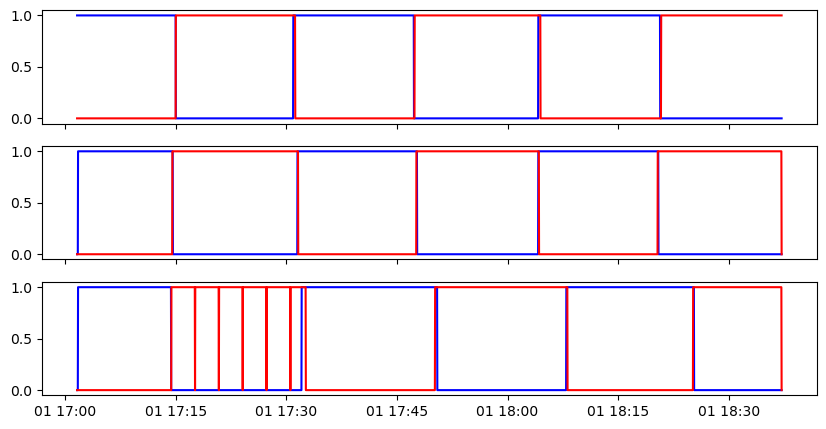

In [64]:
# Convert timestamps to python datetime %H:%M:%S,%f format
df_plot['start_timestamp'] = df_plot['start_timestamp'].str[:-4] + df_plot['start_timestamp'].str[-3:]
df_plot['end_timestamp'] = df_plot['end_timestamp'].str[:-4] + df_plot['end_timestamp'].str[-3:]

df_plot['start_timestamp'] = pd.to_datetime(df_plot['start_timestamp'], format= '%H:%M:%S,%f')#.dt.time
df_plot['end_timestamp'] = pd.to_datetime(df_plot['end_timestamp'], format='%H:%M:%S,%f')#.dt.time

# Generate a range of timestamps using the minimum start timestamp and maximum end timestamp, with a 2-second frequency
x_values = pd.date_range(df_plot['start_timestamp'].min(), df_plot['end_timestamp'].max(), freq='2S')

# Initialize an empty list to store data for each drone at each timestamp
drone_id = []

# Iterate over each timestamp in the x_values range
for x in x_values:
    # For each drone, count the number of entries where the start_timestamp is less than or equal to the current timestamp, 
    # the end_timestamp is greater than the current timestamp, and the folder contains the drone ID
    drone_id.append([
        x, 
        len(df_day.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D1')),:]),
        len(df_day.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D2')),:]),
        len(df_day.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D3')),:]),
        len(df_day.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D4')),:]),
        len(df_day.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D5')),:]),
        len(df_day.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D6')),:])
    ])
    
# Create a pandas DataFrame from the drone_id list
t = pd.DataFrame(drone_id)

# Create a figure with 3 subplots and a shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

# Plot data of drones D1 and D2 on position P1
ax1.plot(t[0], t[1], c='blue')
ax1.plot(t[0], t[2], c='red')

# Plot data of drones D3 and D4 on position P2
ax2.plot(t[0], t[3], c='blue')
ax2.plot(t[0], t[4], c='red')

# Plot data of drones D5 and D6 on position P3
ax3.plot(t[0], t[5], c='blue')
ax3.plot(t[0], t[6], c='red')

# Display the plot
plt.show()    